<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/MSDS458_Assignment_01_v26_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 1:

* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits). 
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images. 
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Importing Packages 

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

## Verify TensorFlow version and Keras version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.2


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Mount Google Drive to Colab environment

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Research Assignment Reporting Functions

In [7]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

# Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [8]:
## Load MNIST data and split into test and train sets

(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

# EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [9]:
## Number of samples in each set

print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


# EDA

## Review labels for training set

In [10]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

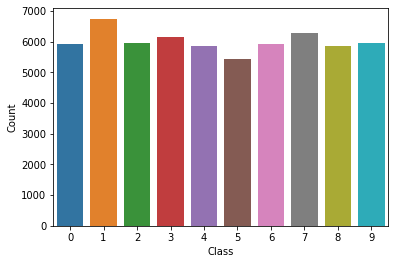

In [11]:
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [12]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [13]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

## Plot sample images with their labels

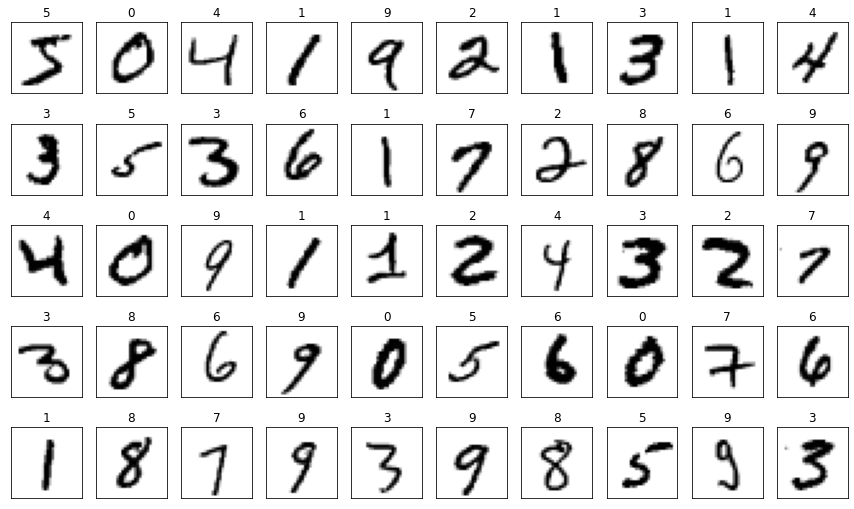

In [14]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

# Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s. 
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [15]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [16]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [17]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [18]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [19]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

## Review unique values with set from 1st image

In [20]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}



## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [21]:
## Normalize: convert pixels in range [0,255] to range [0,1], scales all images to the same size

x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [22]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


In [23]:
model = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


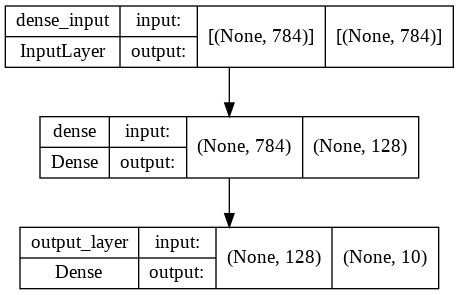

In [25]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 


<b>tf.keras.optimizers.RMSprop</b><br> 
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br> 
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


# Experiment 1
Our dense neural network will consist of 784 input nodes, a hidden layer with 1 node and 10 output nodes (corresponding to the 10 digits). 

We use mnist.load_data() to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. 

We hold back 5,000 of the 60,000 training images for validation. 

After training the model, we group the 60,000 activation values of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a boxplot. We expect the overlap between the range of values in the "boxes" to be minimal. 

In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2.

#### Build, Compile, Train, Evaluate

In [31]:
## Experiment 1 - 1 unit, 10 output units
## Build model

model_1 = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
## Compile

model_1.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [33]:
## Train 

history_1 = model_1.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 7s 4ms/step - loss: 1.9922 - accuracy: 0.2010 - val_loss: 1.8482 - val_accuracy: 0.2530
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.8205 - accuracy: 0.2736 - val_loss: 1.7631 - val_accuracy: 0.3143
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7663 - accuracy: 0.3028 - val_loss: 1.7267 - val_accuracy: 0.3211
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7426 - accuracy: 0.3192 - val_loss: 1.7144 - val_accuracy: 0.3388
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7284 - accuracy: 0.3263 - val_loss: 1.7113 - val_accuracy: 0.3153
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7170 - accuracy: 0.3370 - val_loss: 1.6817 - val_accuracy: 0.3476
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7058 - accuracy: 0.3441 - val_loss: 1.6728 - val_ac

In [34]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.6682 - accuracy: 0.3629
Test acc: 0.363


#### Activation Layer

In [35]:
# Extracts the outputs of the 2 layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

print(f"There are {len(layer_outputs_1)} layers")
layer_outputs_1; # description of the layers

There are 2 layers


In [36]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations_1 = activation_model_1.predict(x_train_norm)
hidden_layer_activation_1 = activations_1[0]
output_layer_activations_1 = activations_1[1]
hidden_layer_activation_1.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 1)

In [37]:
output_layer_activations_1.shape

(60000, 10)

In [38]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation_1.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 15.576287269592285


In [39]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation_1 = activations_1[1]
print(f"The output node has shape {ouput_layer_activation_1.shape}")
print(f"The output for the first image are {ouput_layer_activation_1[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation_1[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.024 0.225 0.073 0.15  0.    0.156 0.15  0.022 0.2   0.   ]
The sum of the probabilities is (approximately) 1.0


In [40]:
#Get the dataframe of all the node values
activation_data_1 = {'actual_class':y_train}
for k in range(0,1): 
    activation_data_1[f"act_val_{k}"] = hidden_layer_activation_1[:,k]

activation_df_1 = pd.DataFrame(activation_data_1)
activation_df_1.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.00,0.0,4.0,1.000,9.0,2.000,1.000,3.000,1.000,4.0,3.000,5.000,3.000,6.000,1.000
act_val_0,2.43,0.0,0.2,3.386,0.0,3.023,4.089,3.967,3.289,0.0,4.082,3.171,5.574,0.788,3.582


### Visualization

#### Boxplot

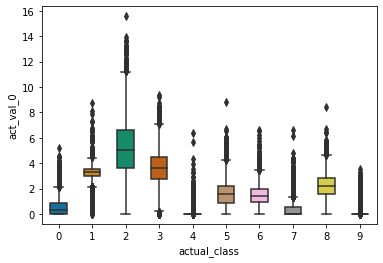

In [41]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot_1 = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df_1[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

#### Confusion Matrix

In [42]:
# Get the predicted classes:
pred_classes = np.argmax(model_1.predict(x_test_norm), axis=-1)
pred_classes;

In [43]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

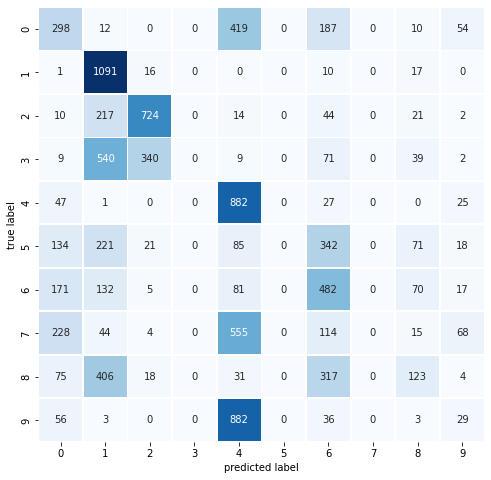

In [44]:
plot_confusion_matrix(y_test,pred_classes)

# Experiment 2
This time our dense neural network will have 784 input nodes, a hidden layer with 2 nodes and 10 output nodes (corresponding to the 10 digits). 

For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. 

We color code the points according to which of the 10 classes the the output of the two nodes predicts. Ideally, just like in EXPERIMENT 1, the color clusters should have very little overlap. 

Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights.

####Build, Compile, Train, Evaluate

In [45]:
## Experiment 2 - 2 unit, 10 output units
## Build model

model_2 = Sequential([
    Dense(input_shape=[784], units=2, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
## Compile

model_2.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [47]:
## Train 

history_2 = model_2.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.5802 - accuracy: 0.4477 - val_loss: 1.2945 - val_accuracy: 0.5653
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.2847 - accuracy: 0.5650 - val_loss: 1.1783 - val_accuracy: 0.6054
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.2113 - accuracy: 0.6037 - val_loss: 1.1037 - val_accuracy: 0.6490
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.1639 - accuracy: 0.6264 - val_loss: 1.0608 - val_accuracy: 0.6701
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.1308 - accuracy: 0.6391 - val_loss: 1.0334 - val_accuracy: 0.6767
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.1065 - accuracy: 0.6469 - val_loss: 1.0200 - val_accuracy: 0.6773
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.0885 - accuracy: 0.6511 - val_loss: 0.9850 - val_ac

In [48]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.0419 - accuracy: 0.6409
Test acc: 0.641


####Activation Layer

In [49]:
# Extracts the outputs of the 2 layers:
layer_outputs_2 = [layer.output for layer in model_2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs_2)

print(f"There are {len(layer_outputs_2)} layers")
layer_outputs_2; # description of the layers

There are 2 layers


In [50]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations_2 = activation_model_2.predict(x_train_norm)
hidden_layer_activation_2 = activations_2[0]
output_layer_activations_2 = activations_2[1]
hidden_layer_activation_2.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 2)

In [51]:
output_layer_activations_2.shape

(60000, 10)

In [52]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation_2.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 17.787452697753906


In [53]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation_2 = activations_2[1]
print(f"The output node has shape {ouput_layer_activation_2.shape}")
print(f"The output for the first image are {ouput_layer_activation_2[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation_2[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.584 0.    0.011 0.275 0.    0.107 0.    0.013 0.009 0.001]
The sum of the probabilities is (approximately) 1.0


In [54]:
#Get the dataframe of all the node values
activation_data_2 = {'actual_class':y_train}
for k in range(0,2): 
    activation_data_2[f"act_val_{k}"] = hidden_layer_activation_2[:,k]

activation_df_2 = pd.DataFrame(activation_data_2)
activation_df_2.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.00,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.00
act_val_0,0.00,0.205,4.094,2.713,7.504,0.000,3.032,1.092,3.004,4.963,1.188,0.638,0.000,1.232,2.94
act_val_1,3.96,6.797,2.676,0.000,6.451,1.733,0.000,3.382,0.000,2.367,4.318,1.047,2.318,0.000,0.00


### Visualization


#### Boxplot

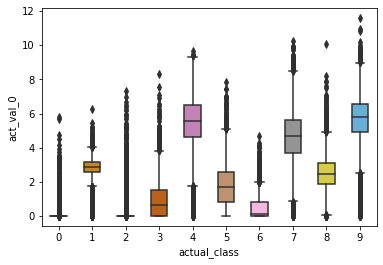

In [55]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot_2 = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df_2[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

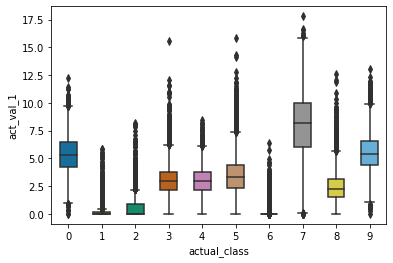

In [56]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot_2 = sns.boxplot(y='act_val_1', x='actual_class', 
                 data=activation_df_2[['act_val_1','actual_class']], 
                 width=0.5,
                 palette="colorblind")

####Scatter Plot

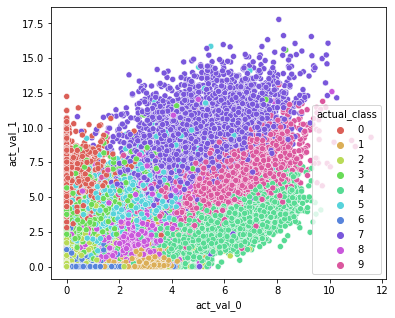

In [57]:
plt.figure(figsize=(6, 5))
color = sns.color_palette("hls", 10)

sns.scatterplot(y='act_val_1', x='act_val_0', 
                 data=activation_df_2, hue = 'actual_class',
                 palette=sns.color_palette("hls", 10),)

####Confusion Matrix

In [58]:
# Get the predicted classes:
pred_classes = np.argmax(model_2.predict(x_test_norm), axis=-1)
pred_classes;

In [59]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

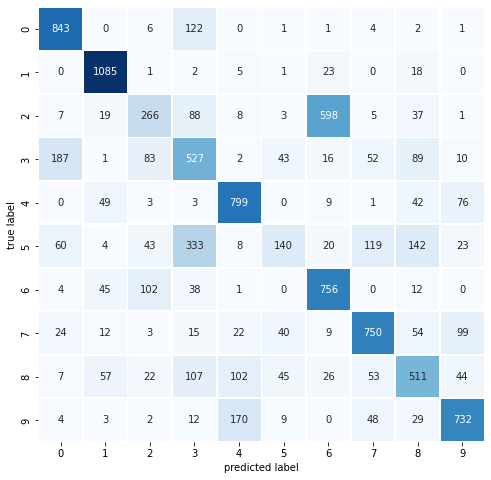

In [60]:
plot_confusion_matrix(y_test,pred_classes)

# Experiment 3
You can explore with more hidden nodes. At least 5 more variations of this architecture NEEDS to be tried. 

Then you end up with 1 ‘final’ model. Say the ‘best’ model.

### Best/final model: Variation 4.3

## Variation 1

####Build, Compile, Train, Evaluate

In [61]:
## Experiment 3, Variation 1 - 5 units, 10 output units
## Build model

model_3_1 = Sequential([
    Dense(input_shape=[784], units=5, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 3925      
                                                                 
 output_layer (Dense)        (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
## Compile

model_3_1.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [63]:
## Train 

history_3_1 = model_3_1.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.9609 - accuracy: 0.7242 - val_loss: 0.5641 - val_accuracy: 0.8677
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.5630 - accuracy: 0.8529 - val_loss: 0.4428 - val_accuracy: 0.8934
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4976 - accuracy: 0.8672 - val_loss: 0.4052 - val_accuracy: 0.8970
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4716 - accuracy: 0.8734 - val_loss: 0.3918 - val_accuracy: 0.9030
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4576 - accuracy: 0.8770 - val_loss: 0.3840 - val_accuracy: 0.9036
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4485 - accuracy: 0.8807 - val_loss: 0.3742 - val_accuracy: 0.9084
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4407 - accuracy: 0.8817 - val_loss: 0.3635 - val_ac

In [64]:
## Evaluate

model_3_1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_1.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.4192 - accuracy: 0.8830
Test acc: 0.883


## Variation 2

####Build, Compile, Train, Evaluate

In [65]:
## Experiment 3, Variation 2 - 10 units, 10 output units
## Build model

model_3_2 = Sequential([
    Dense(input_shape=[784], units=10, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
 output_layer (Dense)        (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
## Compile

model_3_2.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [67]:
## Train 

history_3_2 = model_3_2.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.5983 - accuracy: 0.8472 - val_loss: 0.3083 - val_accuracy: 0.9291
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3612 - accuracy: 0.9135 - val_loss: 0.2727 - val_accuracy: 0.9361
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3343 - accuracy: 0.9203 - val_loss: 0.2598 - val_accuracy: 0.9412
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3189 - accuracy: 0.9235 - val_loss: 0.2577 - val_accuracy: 0.9426
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3076 - accuracy: 0.9255 - val_loss: 0.2401 - val_accuracy: 0.9452
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2981 - accuracy: 0.9275 - val_loss: 0.2424 - val_accuracy: 0.9456
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2916 - accuracy: 0.9292 - val_loss: 0.2411 - val_ac

In [68]:
## Evaluate

model_3_2 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_2.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.2734 - accuracy: 0.9327
Test acc: 0.933


## Variation 3

####Build, Compile, Train, Evaluate

In [69]:
## Experiment 3, Variation 3 - 20 units, 10 output units
## Build model

model_3_3 = Sequential([
    Dense(input_shape=[784], units=20, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                15700     
                                                                 
 output_layer (Dense)        (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
## Compile

model_3_3.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [71]:
## Train 

history_3_3 = model_3_3.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.4691 - accuracy: 0.8828 - val_loss: 0.2738 - val_accuracy: 0.9390
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3084 - accuracy: 0.9256 - val_loss: 0.2316 - val_accuracy: 0.9510
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2754 - accuracy: 0.9343 - val_loss: 0.2177 - val_accuracy: 0.9536
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2558 - accuracy: 0.9402 - val_loss: 0.2098 - val_accuracy: 0.9570
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2421 - accuracy: 0.9432 - val_loss: 0.2129 - val_accuracy: 0.9530
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2308 - accuracy: 0.9462 - val_loss: 0.1981 - val_accuracy: 0.9588
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2219 - accuracy: 0.9482 - val_loss: 0.1990 - val_ac

In [72]:
## Evaluate

model_3_3 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_3.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.1997 - accuracy: 0.9545
Test acc: 0.955


## Variation 4

####Build, Compile, Train, Evaluate

In [73]:
## Experiment 3, Variation 4 - 100 units, 10 output units
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [75]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3826 - accuracy: 0.9168 - val_loss: 0.2219 - val_accuracy: 0.9596
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2314 - accuracy: 0.9518 - val_loss: 0.1858 - val_accuracy: 0.9653
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1967 - accuracy: 0.9603 - val_loss: 0.1654 - val_accuracy: 0.9711
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1780 - accuracy: 0.9636 - val_loss: 0.1505 - val_accuracy: 0.9727
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1679 - accuracy: 0.9671 - val_loss: 0.1733 - val_accuracy: 0.9661
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1609 - accuracy: 0.9676 - val_loss: 0.1478 - val_accuracy: 0.9741
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1553 - accuracy: 0.9683 - val_loss: 0.1619 - val_ac

In [76]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.9695
Test acc: 0.970


### Variation 4.1

####Build, Compile, Train, Evaluate

In [77]:
## Experiment 3, Variation 4.1 - 100 units, 10 output units, Adam optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
## Compile

model_3_4.compile(optimizer='adam',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [79]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3982 - accuracy: 0.9165 - val_loss: 0.2343 - val_accuracy: 0.9616
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2428 - accuracy: 0.9538 - val_loss: 0.1915 - val_accuracy: 0.9691
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2077 - accuracy: 0.9622 - val_loss: 0.1874 - val_accuracy: 0.9711
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1894 - accuracy: 0.9670 - val_loss: 0.1793 - val_accuracy: 0.9695
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1783 - accuracy: 0.9677 - val_loss: 0.1775 - val_accuracy: 0.9693


In [80]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1837 - accuracy: 0.9676
Test acc: 0.968


### Variation 4.2

####Build, Compile, Train, Evaluate

In [81]:
## Experiment 3, Variation 4.2 - 100 units, 10 output units, Adagrad optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [82]:
## Compile

model_3_4.compile(optimizer='Adagrad',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [83]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.5034 - accuracy: 0.6867 - val_loss: 0.9291 - val_accuracy: 0.8717
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.8825 - accuracy: 0.8389 - val_loss: 0.6970 - val_accuracy: 0.8956
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.7402 - accuracy: 0.8628 - val_loss: 0.6096 - val_accuracy: 0.9070
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.6724 - accuracy: 0.8755 - val_loss: 0.5611 - val_accuracy: 0.9159
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.6301 - accuracy: 0.8841 - val_loss: 0.5290 - val_accuracy: 0.9213
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.6003 - accuracy: 0.8893 - val_loss: 0.5060 - val_accuracy: 0.9225
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.5777 - accuracy: 0.8937 - val_loss: 0.4883 - val_ac

In [84]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3780 - accuracy: 0.9317
Test acc: 0.932


### Variation 4.3

####Build, Compile, Train, Evaluate

In [85]:
## Experiment 3, Variation 4.3 - 100 units, 10 output units, RMSprop optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [87]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3898 - accuracy: 0.9152 - val_loss: 0.2199 - val_accuracy: 0.9596
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.2378 - accuracy: 0.9511 - val_loss: 0.1975 - val_accuracy: 0.9629
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2001 - accuracy: 0.9597 - val_loss: 0.1682 - val_accuracy: 0.9707
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1815 - accuracy: 0.9636 - val_loss: 0.1562 - val_accuracy: 0.9735
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1708 - accuracy: 0.9656 - val_loss: 0.1536 - val_accuracy: 0.9761
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1625 - accuracy: 0.9670 - val_loss: 0.1451 - val_accuracy: 0.9743
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1561 - accuracy: 0.9681 - val_loss: 0.1534 - val_ac

In [88]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.1624 - accuracy: 0.9669
Test acc: 0.967


#### Variation 4.3.1

In [89]:
## Experiment 3, Variation 4.3.1 - 100 units, 10 output units, RMSprop optimizer,  Sigmoid output activation
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.sigmoid)
])

print(model_3_4.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [91]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 8s 4ms/step - loss: 0.4228 - accuracy: 0.9082 - val_loss: 0.2474 - val_accuracy: 0.9546
Epoch 2/200
1720/1720 [==============================] - 6s 4ms/step - loss: 0.2563 - accuracy: 0.9471 - val_loss: 0.2160 - val_accuracy: 0.9618
Epoch 3/200
1720/1720 [==============================] - 6s 4ms/step - loss: 0.2150 - accuracy: 0.9553 - val_loss: 0.1739 - val_accuracy: 0.9699
Epoch 4/200
1720/1720 [==============================] - 6s 4ms/step - loss: 0.1922 - accuracy: 0.9607 - val_loss: 0.1861 - val_accuracy: 0.9637
Epoch 5/200
1720/1720 [==============================] - 6s 4ms/step - loss: 0.1763 - accuracy: 0.9641 - val_loss: 0.1967 - val_accuracy: 0.9564


In [92]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1909 - accuracy: 0.9641
Test acc: 0.964


#### Variation 4.3.2

In [93]:
## Experiment 3, Variation 4.3.2 - 100 units, 10 output units, RMSprop optimizer,  ReLU output activation
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.relu)
])

print(model_3_4.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [95]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.6986 - val_loss: nan - val_accuracy: 0.7530
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.4701 - val_loss: nan - val_accuracy: 0.2462
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.2460 - val_loss: 14.6390 - val_accuracy: 0.0918


In [96]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 14.6804 - accuracy: 0.0892
Test acc: 0.089


#### Variation 4.3.3

In [97]:
## Experiment 3, Variation 4.3.3 - 100 units, 10 output units, RMSprop optimizer, tanh output activation
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.tanh)
])

print(model_3_4.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [98]:
## Compile

model_3_4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [99]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 7s 4ms/step - loss: 8.3141 - accuracy: 0.1074 - val_loss: 7.9134 - val_accuracy: 0.0962
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 7.9855 - accuracy: 0.0993 - val_loss: 7.9134 - val_accuracy: 0.0962
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 7.9884 - accuracy: 0.0994 - val_loss: 7.9134 - val_accuracy: 0.0962


In [100]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 8.0413 - accuracy: 0.1009
Test acc: 0.101


### Variation 4.4

####Build, Compile, Train, Evaluate

In [101]:
## Experiment 3, Variation 4.3 - 100 units, 10 output units, Adadelta optimizer 
## Build model

model_3_4 = Sequential([
    Dense(input_shape=[784], units=100, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_4.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               78500     
                                                                 
 output_layer (Dense)        (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
None


In [102]:
## Compile

model_3_4.compile(optimizer='adadelta',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [103]:
## Train 

history_3_4 = model_3_4.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 2.4685 - accuracy: 0.1368 - val_loss: 2.3915 - val_accuracy: 0.1904
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.3343 - accuracy: 0.2536 - val_loss: 2.2582 - val_accuracy: 0.3598
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.2141 - accuracy: 0.4008 - val_loss: 2.1363 - val_accuracy: 0.5086
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 2.1019 - accuracy: 0.5136 - val_loss: 2.0206 - val_accuracy: 0.6066
Epoch 5/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.9950 - accuracy: 0.5899 - val_loss: 1.9093 - val_accuracy: 0.6629
Epoch 6/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.8918 - accuracy: 0.6385 - val_loss: 1.8021 - val_accuracy: 0.7038
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7921 - accuracy: 0.6730 - val_loss: 1.6986 - val_ac

In [104]:
## Evaluate

model_3_4 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_4.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.5411 - accuracy: 0.8990
Test acc: 0.899


In [105]:
## Experiment 3, Variation 6 - 550 units, 10 output units
## Build model

model_3_6 = Sequential([
    Dense(input_shape=[784], units=550, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_6.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 550)               431750    
                                                                 
 output_layer (Dense)        (None, 10)                5510      
                                                                 
Total params: 437,260
Trainable params: 437,260
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
## Compile

model_3_6.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [107]:
## Train 

history_3_6 = model_3_6.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3976 - accuracy: 0.9269 - val_loss: 0.2335 - val_accuracy: 0.9572
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2351 - accuracy: 0.9548 - val_loss: 0.1851 - val_accuracy: 0.9681
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2129 - accuracy: 0.9585 - val_loss: 0.1784 - val_accuracy: 0.9701
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2004 - accuracy: 0.9613 - val_loss: 0.1684 - val_accuracy: 0.9711
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1912 - accuracy: 0.9634 - val_loss: 0.1662 - val_accuracy: 0.9733
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1846 - accuracy: 0.9642 - val_loss: 0.1607 - val_accuracy: 0.9725
Epoch 7/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1788 - accuracy: 0.9653 - val_loss: 0.1728 - val_ac

In [108]:
## Evaluate

model_3_6 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_6.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1815 - accuracy: 0.9638
Test acc: 0.964


## Variation 5

####Build, Compile, Train, Evaluate

In [109]:
## Experiment 3, Variation 5 - 200 units, 10 output units
## Build model

model_3_5 = Sequential([
    Dense(input_shape=[784], units=200, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_3_5.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 200)               157000    
                                                                 
 output_layer (Dense)        (None, 10)                2010      
                                                                 
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
## Compile

model_3_5.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [111]:
## Train 

history_3_5 = model_3_5.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.3859 - accuracy: 0.9220 - val_loss: 0.2256 - val_accuracy: 0.9600
Epoch 2/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.2249 - accuracy: 0.9559 - val_loss: 0.1774 - val_accuracy: 0.9685
Epoch 3/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1920 - accuracy: 0.9616 - val_loss: 0.1632 - val_accuracy: 0.9703
Epoch 4/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1776 - accuracy: 0.9650 - val_loss: 0.1711 - val_accuracy: 0.9689
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1701 - accuracy: 0.9665 - val_loss: 0.1437 - val_accuracy: 0.9769
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 0.1626 - accuracy: 0.9686 - val_loss: 0.1395 - val_accuracy: 0.9749
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 0.1589 - accuracy: 0.9680 - val_loss: 0.1757 - val_ac

In [112]:
## Evaluate

model_3_5 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_3_5.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1568 - accuracy: 0.9695
Test acc: 0.970


# Experiment 4
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). 

We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. 

We then compare the performance of Experiments 3 and 4.

#### Build, Compile, Train, Evaluate

In [113]:
## Experiment 1 - 1 unit, 10 output units
## Build model

model_4 = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

print(model_1.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
## Compile

model_1.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [115]:
## Train 

history_1 = model_1.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.083 # 5,000 (of 60,000) for validation
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.9718 - accuracy: 0.2090 - val_loss: 1.8421 - val_accuracy: 0.2655
Epoch 2/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.8255 - accuracy: 0.2831 - val_loss: 1.7756 - val_accuracy: 0.2869
Epoch 3/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7821 - accuracy: 0.3077 - val_loss: 1.7425 - val_accuracy: 0.3257
Epoch 4/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7579 - accuracy: 0.3240 - val_loss: 1.7212 - val_accuracy: 0.3530
Epoch 5/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7418 - accuracy: 0.3358 - val_loss: 1.7094 - val_accuracy: 0.3404
Epoch 6/200
1720/1720 [==============================] - 6s 3ms/step - loss: 1.7298 - accuracy: 0.3472 - val_loss: 1.6944 - val_accuracy: 0.3596
Epoch 7/200
1720/1720 [==============================] - 5s 3ms/step - loss: 1.7204 - accuracy: 0.3568 - val_loss: 1.6878 - val_ac

In [116]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.7015 - accuracy: 0.3484
Test acc: 0.348


#### Activation Layer

In [117]:
# Extracts the outputs of the 2 layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

print(f"There are {len(layer_outputs_1)} layers")
layer_outputs_1; # description of the layers

There are 2 layers


In [118]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations_1 = activation_model_1.predict(x_train_norm)
hidden_layer_activation_1 = activations_1[0]
output_layer_activations_1 = activations_1[1]
hidden_layer_activation_1.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 1)

In [119]:
output_layer_activations_1.shape

(60000, 10)

In [120]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation_1.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 10.795934677124023


In [121]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation_1 = activations_1[1]
print(f"The output node has shape {ouput_layer_activation_1.shape}")
print(f"The output for the first image are {ouput_layer_activation_1[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation_1[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.234 0.024 0.12  0.224 0.002 0.133 0.    0.172 0.076 0.014]
The sum of the probabilities is (approximately) 1.0


In [122]:
#Get the dataframe of all the node values
activation_data_1 = {'actual_class':y_train}
for k in range(0,1): 
    activation_data_1[f"act_val_{k}"] = hidden_layer_activation_1[:,k]

activation_df_1 = pd.DataFrame(activation_data_1)
activation_df_1.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.000,1.000,9.000,2.0,1.000,3.0,1.000,4.000,3.0,5.0,3.0,6.000,1.000
act_val_0,0.0,0.0,1.907,2.343,3.109,0.0,2.234,0.0,2.314,3.776,0.0,0.0,0.0,6.447,2.449


In [123]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

ValueError: ignored